In [8]:
import argparse
import os
import gzip
import shutil
from multiprocessing import Process, Queue
import time
import warnings
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action="ignore", category=PendingDeprecationWarning)

import logging
log = logging.getLogger(__name__)

import cooler
from sparse_neighbors_search import MinHash
from sparse_neighbors_search import MinHashDBSCAN
from sparse_neighbors_search import MinHashSpectralClustering
from sparse_neighbors_search import MinHashClustering

from hicmatrix import HiCMatrix
from schicexplorer.utilities import opener
from hicmatrix.lib import MatrixFileHandler

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

In [2]:
matrices_name = 'matrices.mcool'

In [3]:
matrices = cooler.fileops.list_coolers(matrices_name)
log.debug('matrices {}'.format(matrices))
neighborhood_matrix = None
for i, matrix in enumerate(matrices):
    matrixFileHandlerInput = MatrixFileHandler(pFileType='cool', pMatrixFile=matrices_name+ '::' +matrix)
    _matrix, _, _, \
            _, _ = matrixFileHandlerInput.load()

    if neighborhood_matrix is None:
        neighborhood_matrix = csr_matrix((len(matrices), _matrix.shape[0] * _matrix.shape[1]), dtype=int)

    instances, features = _matrix.nonzero()

    instances *= _matrix.shape[1]
    instances += features
    features = None
    neighborhood_matrix[i, instances] = 1 #TODO this is so far wrong


In [4]:
minHash = MinHash(number_of_hash_functions=400, number_of_cores=4, fast=True)
minHash.fit(neighborhood_matrix)
print(minHash.kneighbors_graph(mode='distance'))

  (0, 0)	0.0
  (0, 2)	0.36000001430511475
  (0, 4)	0.13999998569488525
  (0, 6)	0.13999998569488525
  (0, 9)	0.18000000715255737
  (0, 16)	0.1600000262260437
  (0, 20)	0.25
  (1, 1)	0.0
  (1, 6)	0.25999999046325684
  (1, 9)	0.24000000953674316
  (1, 13)	0.25
  (1, 14)	0.23000001907348633
  (2, 0)	0.36000001430511475
  (2, 2)	0.0
  (2, 7)	0.3500000238418579
  (2, 14)	0.36000001430511475
  (2, 16)	0.38999998569488525
  (3, 3)	0.0
  (3, 4)	0.30000001192092896
  (3, 13)	0.3199999928474426
  (3, 14)	0.3199999928474426
  (3, 21)	0.3100000023841858
  (4, 0)	0.13999998569488525
  (4, 3)	0.30000001192092896
  (4, 4)	0.0
  :	:
  (20, 4)	0.25
  (20, 6)	0.23000001907348633
  (20, 10)	0.3100000023841858
  (20, 18)	0.26999998092651367
  (20, 19)	0.20999997854232788
  (20, 20)	0.0
  (21, 3)	0.3100000023841858
  (21, 4)	0.25999999046325684
  (21, 6)	0.17000001668930054
  (21, 8)	0.3399999737739563
  (21, 14)	0.25
  (21, 21)	0.0
  (21, 23)	0.25999999046325684
  (22, 4)	0.2200000286102295
  (22, 6)	0.19

In [79]:

# log.debug('neighborhood_matrix {}'.format(neighborhood_matrix))
# minHash = MinHash(number_of_hash_functions=20, number_of_cores=4)
# minHash.fit(neighborhood_matrix)
# print(minHash.kneighbors_graph(mode='distance'))
# minHashDbscan = MinHashDBSCAN(number_of_hash_functions=20, number_of_cores=4)
# # minHashClustering = MinHashClustering(minHash)
# print(minHashDbscan.fit_predict(neighborhood_matrix))

minHashSpectralClustering = MinHashSpectralClustering(n_clusters=6, number_of_hash_functions=400, number_of_cores=4,
                                                      shingle_size=1, fast=False)
# minHashClustering = MinHashClustering(minHash)
# print(minHashSpectralClustering.fit_predict(neighborhood_matrix))
labels_clustering = minHashSpectralClustering.fit_predict(neighborhood_matrix)

In [6]:
minHashDbscan = MinHashDBSCAN(eps=0.15, min_samples=1, number_of_hash_functions=20, number_of_cores=4, fast=True)
# minHashClustering = MinHashClustering(minHash)
labels_clustering = minHashDbscan.fit_predict(neighborhood_matrix)
print(labels_clustering)

[ 0  1  2  3  4  5  4  4  6  7  8  9  4  4  4 10  4  4  4 11  4  4  4  4]


In [9]:
labels_clustering = np.delete(labels_clustering, 2)

In [10]:
labels_clustering = np.delete(labels_clustering, 9)

In [80]:
neighborhood_matrix_to_transform = neighborhood_matrix.todense()
# neighborhood_matrix_to_transform = np.delete(neighborhood_matrix_to_transform, 2, 0)
# neighborhood_matrix_to_transform = np.delete(neighborhood_matrix_to_transform, 9, 0)

,0,1,label
0,-6.494261,-5.054365,0
1,-19.109188,-4.135468,1
2,-6.176544,-39.568903,3
3,-10.440783,-1.925482,4
4,-13.220116,3.778173,5
5,-12.103362,0.385126,4
6,2.594651,-3.568285,4
7,-18.258600,-2.508383,6
8,8.481976,-11.225348,7
9,-21.103685,13.364967,9


In [81]:
pca = sklearnPCA(n_components=2) #2-dimensional PCA
transformed = pd.DataFrame(pca.fit_transform(neighborhood_matrix_to_transform))

In [82]:
lda = LDA(n_components=2)
lda_transformed = pd.DataFrame(lda.fit_transform(neighborhood_matrix_to_transform, labels_clustering))

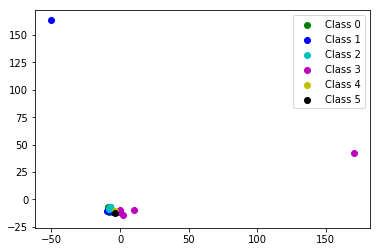

In [83]:

transformed['label'] = labels_clustering
colors = ['g', 'b', 'c', 'm', 'y', 'k']
for label in set(labels_clustering):
    plt.scatter(transformed[transformed['label'] == label][0], transformed[transformed['label'] == label][1], label='Class '+str(label), c=colors[label%len(colors)])

plt.legend()
plt.show()

In [17]:
lda_transformed['label'] = labels_clustering

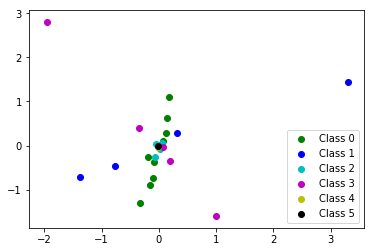

In [84]:
lda_transformed['label'] = labels_clustering
colors = ['g', 'b', 'c', 'm', 'y', 'k']
for label in set(labels_clustering):
    plt.scatter(lda_transformed[transformed['label'] == label][0], lda_transformed[transformed['label'] == label][1], label='Class '+str(label), c=colors[label%len(colors)])

plt.legend()
plt.show()

In [20]:
import networkx as nx

In [200]:
minHash_graph = minHash.kneighbors_graph(mode='distance', n_neighbors=-1)

In [201]:
minHash_graph.max()

0.5699999928474426

In [203]:
for i in range(len(minHash_graph.data)):
    minHash_graph.data[i] = 1.0 / (1.0 + minHash_graph.data[i])
# minHash_graph = 1.0 / (1.0 + minHash_graph)

In [64]:
foo = minHash_graph * 100


In [204]:
print(minHash_graph)

  (0, 0)	1.0
  (0, 1)	0.7575757616807607
  (0, 2)	0.7352941099128922
  (0, 3)	0.7575757616807607
  (0, 4)	0.8771929934634618
  (0, 5)	0.7352941099128922
  (0, 6)	0.8771929934634618
  (0, 7)	0.7462686713221454
  (0, 8)	0.6896551780836762
  (0, 9)	0.8474576219817888
  (0, 10)	0.6993006958029452
  (0, 11)	0.7042253438358955
  (0, 12)	0.7462686713221454
  (0, 13)	0.7812500174622987
  (0, 14)	0.8130081174740657
  (0, 15)	0.8064516067008695
  (0, 16)	0.8620689460270191
  (0, 17)	0.7751937855551518
  (0, 18)	0.7518797086829673
  (0, 19)	0.7407407276587887
  (0, 20)	0.8
  (0, 21)	0.7874015866287349
  (0, 22)	0.7751937855551518
  (0, 23)	0.7352941099128922
  (1, 0)	0.7575757616807607
  :	:
  (22, 23)	0.7407407276587887
  (23, 0)	0.7352941099128922
  (23, 1)	0.7407407276587887
  (23, 2)	0.684931516915778
  (23, 3)	0.7246376836632911
  (23, 4)	0.8130081174740657
  (23, 5)	0.6944444455942254
  (23, 6)	0.8771929934634618
  (23, 7)	0.7352941099128922
  (23, 8)	0.7352941099128922
  (23, 9)	0.74074072

In [205]:
G = nx.Graph(minHash_graph)

In [70]:
pos = nx.get_node_attributes(G, 'pos')

In [87]:
pos_graph = {}
for i, (x, y) in enumerate(zip(transformed[0].values, transformed[1].values)):
    pos_graph[i] = [x,y]

{0: [-6.494260788640289, -5.054365074193448],
 1: [-19.109188345134875, -4.135467783308654],
 2: [-6.176544216388012, -39.56890330882606],
 3: [-10.440782554807253, -1.9254818055090157],
 4: [-13.220115939321428, 3.7781725766517433],
 5: [-12.10336187058939, 0.38512591464008905],
 6: [2.5946508040793725, -3.5682854981642342],
 7: [-18.258599596838124, -2.50838265318937],
 8: [8.481975557752854, -11.225347525390044],
 9: [-21.103684532876162, 13.364967209293196],
 10: [-7.549534130239756, -3.1680565400751783],
 11: [-8.070396326233496, 0.2549613833725985],
 12: [-12.633381630785324, 3.6026267303714525],
 13: [-12.072043401526988, -0.3820146277787765],
 14: [-15.120203236115737, 2.9815424057289635],
 15: [-25.041330234603745, 6.491767495882486],
 16: [-17.578087949763354, -9.432295802397663],
 17: [70.2269787901512, 127.34519611247863],
 18: [18.050861412067327, -13.439313418053192],
 19: [-3.2431981805789087, -3.3333626656697284],
 20: [125.05703882745146, -68.03874115391513],
 21: [-16

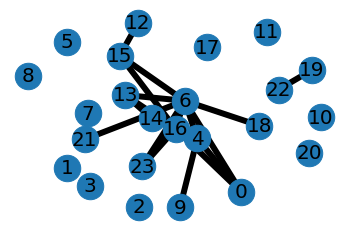

In [111]:
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > 85]
# esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] <= 0.8]

nx.draw_networkx_nodes(G, pos, node_size=700)
nx.draw_networkx_edges(G, pos, edgelist=elarge,
                       width=6)
# nx.draw_networkx_edges(G, pos, edgelist=esmall,
#                        width=, alpha=0.1, edge_color='b', style='dashed')
nx.draw_networkx_labels(G, pos, font_size=20, font_family='sans-serif')

plt.axis('off')
plt.show()

In [179]:
G

In [206]:
sorted(G.degree, key=lambda x: x[1], reverse=True)

[(0, 25),
 (1, 25),
 (2, 25),
 (3, 25),
 (4, 25),
 (5, 25),
 (6, 25),
 (7, 25),
 (8, 25),
 (9, 25),
 (10, 25),
 (11, 25),
 (12, 25),
 (13, 25),
 (14, 25),
 (15, 25),
 (16, 25),
 (17, 25),
 (18, 25),
 (19, 25),
 (20, 25),
 (21, 25),
 (22, 25),
 (23, 25)]

In [229]:
max_degree = sorted(elarge, key=lambda x: x[1], reverse=True)

In [230]:
max_degree

[(4, 23),
 (6, 23),
 (14, 23),
 (16, 23),
 (23, 23),
 (4, 22),
 (6, 22),
 (19, 22),
 (22, 22),
 (6, 21),
 (21, 21),
 (6, 20),
 (19, 20),
 (20, 20),
 (19, 19),
 (4, 18),
 (6, 18),
 (13, 18),
 (18, 18),
 (4, 17),
 (6, 17),
 (16, 17),
 (17, 17),
 (0, 16),
 (6, 16),
 (9, 16),
 (13, 16),
 (14, 16),
 (15, 16),
 (16, 16),
 (0, 15),
 (4, 15),
 (6, 15),
 (7, 15),
 (12, 15),
 (13, 15),
 (14, 15),
 (15, 15),
 (0, 14),
 (1, 14),
 (4, 14),
 (6, 14),
 (7, 14),
 (9, 14),
 (13, 14),
 (14, 14),
 (4, 13),
 (6, 13),
 (12, 13),
 (13, 13),
 (12, 12),
 (11, 11),
 (10, 10),
 (0, 9),
 (1, 9),
 (4, 9),
 (9, 9),
 (8, 8),
 (6, 7),
 (7, 7),
 (0, 6),
 (4, 6),
 (6, 6),
 (5, 5),
 (0, 4),
 (4, 4),
 (3, 3),
 (2, 2),
 (1, 1),
 (0, 0)]

In [209]:
p = dict(nx.single_source_shortest_path_length(G, max_degree))

In [213]:
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > 0.8]

[(0, 0),
 (0, 4),
 (0, 6),
 (0, 9),
 (0, 14),
 (0, 15),
 (0, 16),
 (1, 1),
 (1, 9),
 (1, 14),
 (2, 2),
 (3, 3),
 (4, 4),
 (4, 6),
 (4, 9),
 (4, 13),
 (4, 14),
 (4, 15),
 (4, 17),
 (4, 18),
 (4, 22),
 (4, 23),
 (5, 5),
 (6, 6),
 (6, 7),
 (6, 13),
 (6, 14),
 (6, 15),
 (6, 16),
 (6, 17),
 (6, 18),
 (6, 20),
 (6, 21),
 (6, 22),
 (6, 23),
 (7, 7),
 (7, 14),
 (7, 15),
 (8, 8),
 (9, 9),
 (9, 14),
 (9, 16),
 (10, 10),
 (11, 11),
 (12, 12),
 (12, 13),
 (12, 15),
 (13, 13),
 (13, 14),
 (13, 15),
 (13, 16),
 (13, 18),
 (14, 14),
 (14, 15),
 (14, 16),
 (14, 23),
 (15, 15),
 (15, 16),
 (16, 16),
 (16, 17),
 (16, 23),
 (17, 17),
 (18, 18),
 (19, 19),
 (19, 20),
 (19, 22),
 (20, 20),
 (21, 21),
 (22, 22),
 (23, 23)]

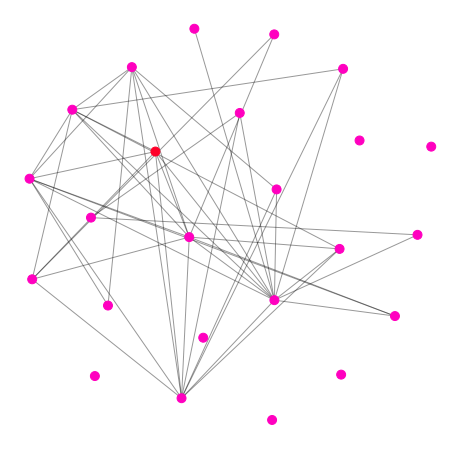

In [217]:
pos = nx.spring_layout(G, k=1)
plt.figure(figsize=(8, 8))
nx.draw_networkx_edges(G, pos, nodelist=[0], edgelist=elarge, alpha=0.4)
nx.draw_networkx_nodes(G, pos, nodelist=list(p.keys()), 
                       node_size=80,
                       node_color=list(p.values()),
                       cmap=plt.cm.gist_rainbow)

# plt.xlim(-0.05, 1.05)
# plt.ylim(-0.05, 1.05)
plt.axis('off')
plt.show()

In [73]:
pos

{0: array([-0.24082231,  0.77068295]),
 1: array([0.27416748, 0.58949881]),
 2: array([0.04844668, 0.30211413]),
 3: array([ 0.09191606, -0.70077486]),
 4: array([-0.32252419, -0.00370107]),
 5: array([ 0.700523  , -0.33529183]),
 6: array([-0.13912632, -0.04172114]),
 7: array([-0.08214563, -0.46397915]),
 8: array([ 0.81845891, -0.0139176 ]),
 9: array([0.26065746, 0.85940449]),
 10: array([-0.60047444, -0.33596469]),
 11: array([-0.88984783,  0.03829103]),
 12: array([ 1.        , -0.16548096]),
 13: array([0.28134792, 0.04579349]),
 14: array([ 0.08529683, -0.18301014]),
 15: array([ 0.57347699, -0.65178043]),
 16: array([0.48943445, 0.41297402]),
 17: array([-0.35568475,  0.40068086]),
 18: array([-0.64694733,  0.61249802]),
 19: array([-0.84965178, -0.30529582]),
 20: array([-0.83321372,  0.29475663]),
 21: array([ 0.37934506, -0.43545685]),
 22: array([-0.57091808, -0.67796289]),
 23: array([ 0.52828555, -0.01235699])}

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.decomposition import PCA as sklearnPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.datasets.samples_generator import make_blobs

# from pandas.tools.plotting import parallel_coordinates

In [11]:
X, y = make_blobs(n_samples=200, centers=3, n_features=2, random_state=0)


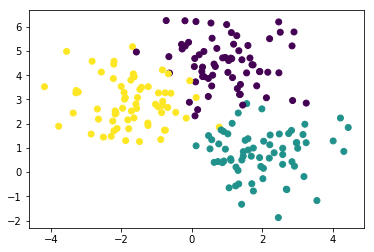

In [14]:
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

In [15]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'
cols =  ['Class', 'Alcohol', 'MalicAcid', 'Ash', 'AlcalinityOfAsh', 'Magnesium', 'TotalPhenols', 
         'Flavanoids', 'NonflavanoidPhenols', 'Proanthocyanins', 'ColorIntensity', 
         'Hue', 'OD280/OD315', 'Proline']
data = pd.read_csv(url, names=cols)

y = data['Class']          # Split off classifications
X = data.ix[:, 'Alcohol':] # Split off features

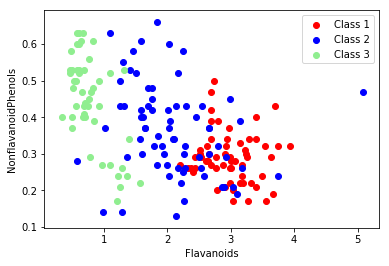

In [17]:
# three different scatter series so the class labels in the legend are distinct
plt.scatter(X[y==1]['Flavanoids'], X[y==1]['NonflavanoidPhenols'], label='Class 1', c='red')
plt.scatter(X[y==2]['Flavanoids'], X[y==2]['NonflavanoidPhenols'], label='Class 2', c='blue')
plt.scatter(X[y==3]['Flavanoids'], X[y==3]['NonflavanoidPhenols'], label='Class 3', c='lightgreen')

# Prettify the graph
plt.legend()
plt.xlabel('Flavanoids')
plt.ylabel('NonflavanoidPhenols')

# display
plt.show()

In [26]:
X_norm = (neighborhood_matrix - neighborhood_matrix.min())/(neighborhood_matrix.max() - neighborhood_matrix.min())


In [30]:
X_norm

<24x7529536 sparse matrix of type '<class 'numpy.float64'>'
	with 650322 stored elements in Compressed Sparse Row format>

In [31]:
import numpy as np

In [33]:
corrmatrix = np.cov(X_norm.todense())

In [35]:
pca = sklearnPCA(n_components=2) #2-dimensional PCA
transformed = pd.DataFrame(pca.fit_transform(X_norm.todense()))


In [42]:
transformed['label'] = labels_clustering

In [43]:
transformed

,0,1,label
0,-6.887874,-7.651270,1
1,-8.994270,-10.143428,6
2,-50.677353,163.532528,1
3,-3.620040,-12.174433,2
4,-7.189306,-7.201640,1
5,-9.165578,-8.202448,1
6,-7.713749,-7.841100,1
7,-4.086945,-10.426627,3
8,-8.314678,-11.650242,1
9,-0.303515,-10.136707,7


In [48]:
transformed[transformed['label'] == 1][1]

0      -7.651270
2     163.532528
4      -7.201640
5      -8.202448
6      -7.841100
8     -11.650242
13     -7.051226
15     -6.801005
16     -7.200738
17     -8.991479
22     -9.358840
23     -9.554364
Name: 1, dtype: float64

In [24]:
pca.fit_transform(X_norm)

array([[-7.06335756e-01, -2.53192753e-01],
       [-4.84976802e-01, -8.82289142e-03],
       [-5.21172266e-01, -1.89187222e-01],
       [-8.21643663e-01, -5.80905512e-01],
       [-2.02546382e-01, -5.94665740e-02],
       [-6.08190152e-01, -4.87519191e-01],
       [-5.44047399e-01, -3.00196497e-01],
       [-4.74357495e-01, -2.98197021e-01],
       [-5.00432012e-01, -3.07602859e-01],
       [-6.27517969e-01, -2.06328233e-01],
       [-7.27467157e-01, -3.56512044e-01],
       [-3.74967744e-01, -2.25424535e-01],
       [-4.48188283e-01, -2.31938139e-01],
       [-6.26345329e-01, -3.55138677e-01],
       [-8.35717011e-01, -5.38047802e-01],
       [-4.71931568e-01, -3.37405385e-01],
       [-4.26990905e-01, -4.50842684e-01],
       [-3.66595704e-01, -3.15750341e-01],
       [-7.18788533e-01, -5.93881332e-01],
       [-4.58884986e-01, -1.75782240e-01],
       [-6.61852288e-01, -1.27831032e-01],
       [-2.67900032e-01,  9.81127565e-03],
       [-5.99782399e-01,  7.82494523e-04],
       [-4.

,0,1


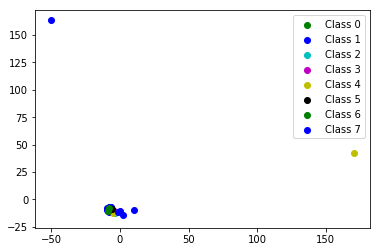

In [51]:
colors = ['g', 'b', 'c', 'm', 'y', 'k']
for label in set(labels_clustering):
    plt.scatter(transformed[transformed['label'] == label][0], transformed[transformed['label'] == label][1], label='Class '+str(label), c=colors[label%len(colors)])

plt.legend()
plt.show()